# Credit Risk Modeling - Take-Home Assignment


---

## Objective

Build a production-ready modeling workflow to predict the probability of 12-month loan default.

---

## Table of Contents

1. [Setup & Data Loading](#1-setup--data-loading)
2. [Exploratory Data Analysis (EDA)](#2-exploratory-data-analysis-eda)
3. [Data Preprocessing & Feature Engineering](#3-data-preprocessing--feature-engineering)
4. [Model Training](#4-model-training)
5. [Model Evaluation & Comparison](#5-model-evaluation--comparison)
6. [Model Interpretation](#6-model-interpretation)
7. [Discussion & Next Steps](#7-discussion--next-steps)

---


## 1. Setup & Data Loading


In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    roc_auc_score, 
    roc_curve, 
    precision_recall_curve,
    classification_report,
    confusion_matrix
)

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Set visualization style
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)


In [2]:
# Load data
df = pd.read_csv('../data/credit_risk_data.csv')

print(f"Dataset shape: {df.shape}")
print(f"\nFirst few rows:")
df.head()


Dataset shape: (10000, 15)

First few rows:


,fico_score,income,debt_to_income,num_open_trades,utilization_rate,inquiries_last_6m,loan_amount,term,apr,channel,product_type,employment_length,state,age,default_12m
0,607,26556,0.59,7,0.22,1.0,45348,60,7.61,Direct,Personal,32.0,TX,59,0
1,553,61853,0.56,10,0.28,3.0,23059,36,7.78,Direct,Auto,2.0,IL,67,0
2,735,171349,0.15,2,0.05,3.0,19965,36,30.66,Mail,Debt_Consolidation,23.0,NY,31,0
3,675,62834,0.37,8,0.99,10.0,46099,60,11.59,Direct,Auto,2.0,CA,72,1
4,711,75738,0.52,12,0.88,10.0,31071,36,12.95,Direct,Home_Improvement,37.0,TX,48,1


## 2. Exploratory Data Analysis (EDA)

### 2.1 Basic Data Overview


In [3]:
# Dataset info
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   fico_score         10000 non-null  int64  
 1   income             10000 non-null  int64  
 2   debt_to_income     9803 non-null   float64
 3   num_open_trades    10000 non-null  int64  
 4   utilization_rate   10000 non-null  float64
 5   inquiries_last_6m  9801 non-null   float64
 6   loan_amount        10000 non-null  int64  
 7   term               10000 non-null  int64  
 8   apr                10000 non-null  float64
 9   channel            10000 non-null  object 
 10  product_type       10000 non-null  object 
 11  employment_length  9805 non-null   float64
 12  state              10000 non-null  object 
 13  age                10000 non-null  int64  
 14  default_12m        10000 non-null  int64  
dtypes: float64(5), int64(7), object(3)
memory usage: 1.1+ MB


In [4]:
# Summary statistics
df.describe()


,fico_score,income,debt_to_income,num_open_trades,utilization_rate,inquiries_last_6m,loan_amount,term,apr,employment_length,age,default_12m
count,10000.000000,10000.000000,9803.000000,10000.000000,10000.000000,9801.000000,10000.000000,10000.000000,10000.000000,9805.000000,10000.000000,10000.000000
mean,701.509200,109889.075300,0.398637,10.071900,0.500934,4.950311,25544.776400,43.243200,20.029878,19.958287,48.232900,0.308100
std,86.472846,51801.713103,0.231142,6.054733,0.294047,3.174047,14146.758709,11.017486,8.700206,11.877940,15.964559,0.461731
min,550.000000,20014.000000,0.000000,0.000000,0.000000,0.000000,1011.000000,36.000000,5.000000,0.000000,21.000000,0.000000
25%,626.000000,64966.000000,0.200000,5.000000,0.250000,2.000000,13336.750000,36.000000,12.587500,10.000000,34.000000,0.000000
50%,702.000000,109847.500000,0.400000,10.000000,0.500000,5.000000,25640.500000,36.000000,19.955000,20.000000,48.000000,0.000000
75%,776.000000,154182.750000,0.600000,15.000000,0.752500,8.000000,37761.000000,60.000000,27.702500,30.000000,62.000000,1.000000
max,850.000000,199992.000000,0.800000,20.000000,1.500000,10.000000,49989.000000,60.000000,35.000000,40.000000,75.000000,1.000000


In [5]:
# Check for missing values
missing_values = df.isnull().sum()
missing_pct = (missing_values / len(df)) * 100
missing_df = pd.DataFrame({'Missing_Count': missing_values, 'Missing_Percentage': missing_pct})
missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)


,Missing_Count,Missing_Percentage
inquiries_last_6m,199,1.99
debt_to_income,197,1.97
employment_length,195,1.95


Default Rate: 30.81%

Class Distribution:
default_12m
0    6919
1    3081
Name: count, dtype: int64


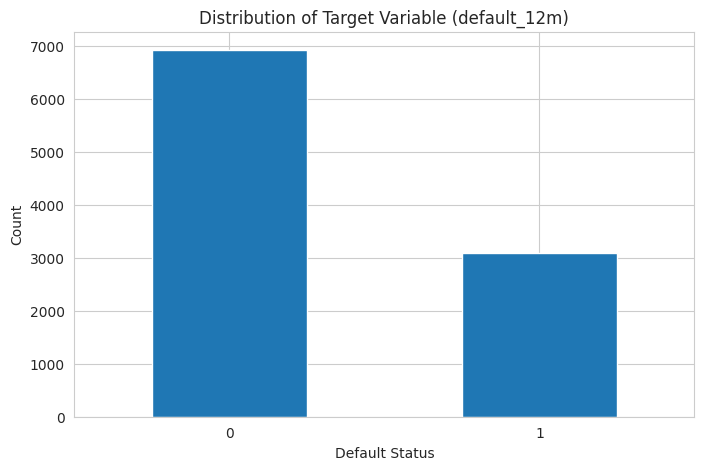

In [6]:
# Target variable distribution
print(f"Default Rate: {df['default_12m'].mean():.2%}")
print(f"\nClass Distribution:")
print(df['default_12m'].value_counts())

# Visualize
plt.figure(figsize=(8, 5))
df['default_12m'].value_counts().plot(kind='bar')
plt.title('Distribution of Target Variable (default_12m)')
plt.xlabel('Default Status')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()


### 2.2 Feature Analysis

TODO: Add your EDA analysis here:
- Distribution plots for numerical features
- Correlation analysis
- Outlier detection
- Relationship between features and target variable
- Analysis of categorical variables


In [ ]:
# Your EDA code here



## 3. Data Preprocessing & Feature Engineering

### 3.1 Handle Missing Values


In [ ]:
# Your preprocessing code here



### 3.2 Handle Outliers


In [ ]:
# Your outlier handling code here



### 3.3 Feature Engineering


In [ ]:
# Your feature engineering code here



### 3.4 Encode Categorical Variables


In [ ]:
# Your encoding code here



### 3.5 Train/Test Split


In [ ]:
# Split data
# X_train, X_test, y_train, y_test = train_test_split(...)



## 4. Model Training

### 4.1 Model 1: Logistic Regression


In [ ]:
# Train logistic regression model



### 4.2 Model 2: Gradient Boosting / XGBoost / LightGBM


In [ ]:
# Train gradient boosting model



## 5. Model Evaluation & Comparison

### 5.1 Calculate Metrics (AUC, KS, Precision-Recall)


In [ ]:
# Calculate and compare metrics



### 5.2 ROC Curves


In [ ]:
# Plot ROC curves



### 5.3 Precision-Recall Curves


In [ ]:
# Plot precision-recall curves



## 6. Model Interpretation

### 6.1 Feature Importance


In [ ]:
# Analyze feature importance



### 6.2 Key Drivers of Default


In [ ]:
# Interpret key drivers



## 7. Discussion & Next Steps

### 7.1 Model Assumptions

TODO: Discuss assumptions made by your models:
- Logistic Regression assumptions (linearity, independence, etc.)
- Tree-based model assumptions
- Any data assumptions

### 7.2 Potential Data Leakage

TODO: Discuss potential sources of data leakage:
- Features that might contain information about the target
- Temporal considerations
- Other leakage risks

### 7.3 Model Improvements

TODO: Discuss how you would improve model performance:
- Additional feature engineering
- Hyperparameter tuning
- Ensemble methods
- External data sources
- Handling class imbalance

### 7.4 Production Considerations

TODO: Discuss production deployment considerations:
- Model monitoring
- Performance degradation
- Scalability
- Interpretability requirements
- Regulatory compliance

---

## Summary

TODO: Provide a brief summary of your findings:
- Best performing model and why
- Key insights about default risk
- Recommendations for deployment

---
